##### imports

In [1]:
import csv
import numpy as np
import pandas as pd
import scipy as sp

import time as tm
import timeit

import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import mpld3 #interactive plot -> mpld3.enable_notebook()
from mpl_toolkits.mplot3d import Axes3D
# create custom color maps
from matplotlib import cm
plt.style.use('default')
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import os
from os import listdir
import glob
from tqdm import tqdm

import sklearn
import sklearn.mixture
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import phate

In [69]:
import plotly.express as px
import plotly.graph_objects as go

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.tsatools import lagmat

In [3]:
from Connectome_Template_functions import subject_data, plot_BOLD_ts, calc_FC, calc_FCs_ut, \
calc_FCs_stream_variants, calc_FCD, calc_edge_ts, calc_RSS, run_KMeans, PCA_sklearn, \
calc_FCD_states, create_2D_brain_plot

In [4]:
parameters = {'axes.labelsize': 22,
              'axes.titlesize': 22,
              'legend.fontsize': 22,
              'xtick.labelsize': 22,
             'ytick.labelsize': 22}
plt.rcParams.update(parameters)
plt.rcParams["figure.figsize"] = (10,6)

In [5]:
# sampling frequency of the BOLD signal
TR = 0.72

In [6]:
preprocessings = ['dicer', 'gsr', 'orig']

In [192]:
data_list, weights = subject_data(os.path.split(os.getcwd())[0], '/data/ins-amu SipEtAl22_ParamInferenceWithUnknownDynamics main study-data/101309/',
                                             'npy', '/region_names.txt', '/weights.txt', use_time=False, sampling_rate=TR)

In [193]:
N_samples, N_regions = data_list[0].shape

In [9]:
# BOLD_plot = plot_BOLD_ts(subj09_data)

### data analysis pipeline

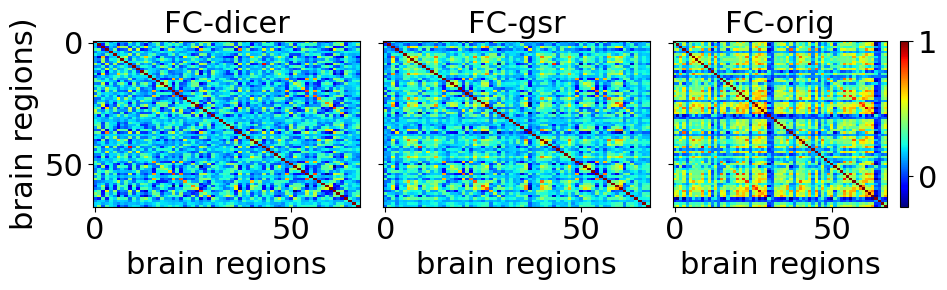

In [10]:
FC_list = calc_FC(data_list, preprocessings, plot=True)

In [11]:
FCs_ut_list, windowed_time = calc_FCs_ut(data_list, 30, use_time=False, sampling_rate=TR)

In [12]:
# samples x upper triagonal elements
FCs_ut_list[0].shape

(1171, 2278)

In [13]:
FC_stream, _ = calc_FCs_stream_variants(data_list, FCs_ut_list)

In [14]:
FC_stream[0].shape

(1171,)

In [15]:
FCDs_list = calc_FCD(data_list, FCs_ut_list)

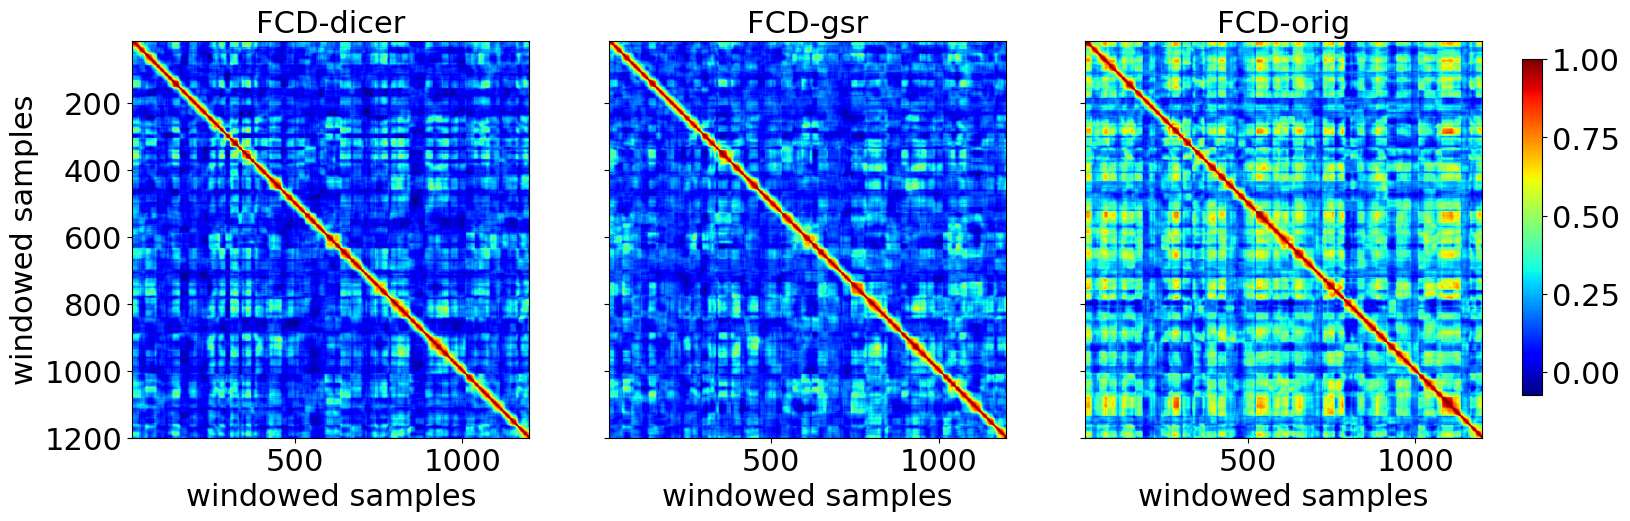

In [16]:
fig, ax = plt.subplots(1,3, sharey=True,figsize = (20,24))
use_time = False
if use_time == True:
    xlabel = 'windowed time'
else:
    xlabel = 'windowed samples'

for i in range(len(data_list)):

    im3 = ax[i].imshow(FCDs_list[i], cmap='jet', aspect='equal', interpolation='none',
                      extent=[windowed_time[0], windowed_time[-1], windowed_time[-1], windowed_time[0]])
    ax[i].set_xlabel(xlabel)
    ax[i].set_title('FCD-'+preprocessings[i])
ax[0].set_ylabel(xlabel)#, fontsize=11)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.43, 0.01, 0.14])
plt.colorbar(im3, cax=cbar_ax, shrink = 0.15);

# plt.tight_layout();

In [17]:
Enm_list, Enm_ut_list = calc_edge_ts(data_list)

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.19it/s]


##### RSS, coactivation events

In [134]:
RSS_list, RSS_95th_percentile_list, RSS_colors_strings = calc_RSS(data_list, Enm_list, coactivation_color='gold')

In [132]:
n_Enm_clusters = [2,3,4]
km_colors = ['green', 'cyan', 'brown', 'darkorange', 'purple', 'k']

In [20]:
km_Enm_labels_list, silh_Enm_avg_list, best_idx_Enm__list = run_KMeans(Enm_ut_list, n_Enm_clusters)

100%|█████████████████████████████████████████████| 3/3 [00:18<00:00,  6.03s/it]


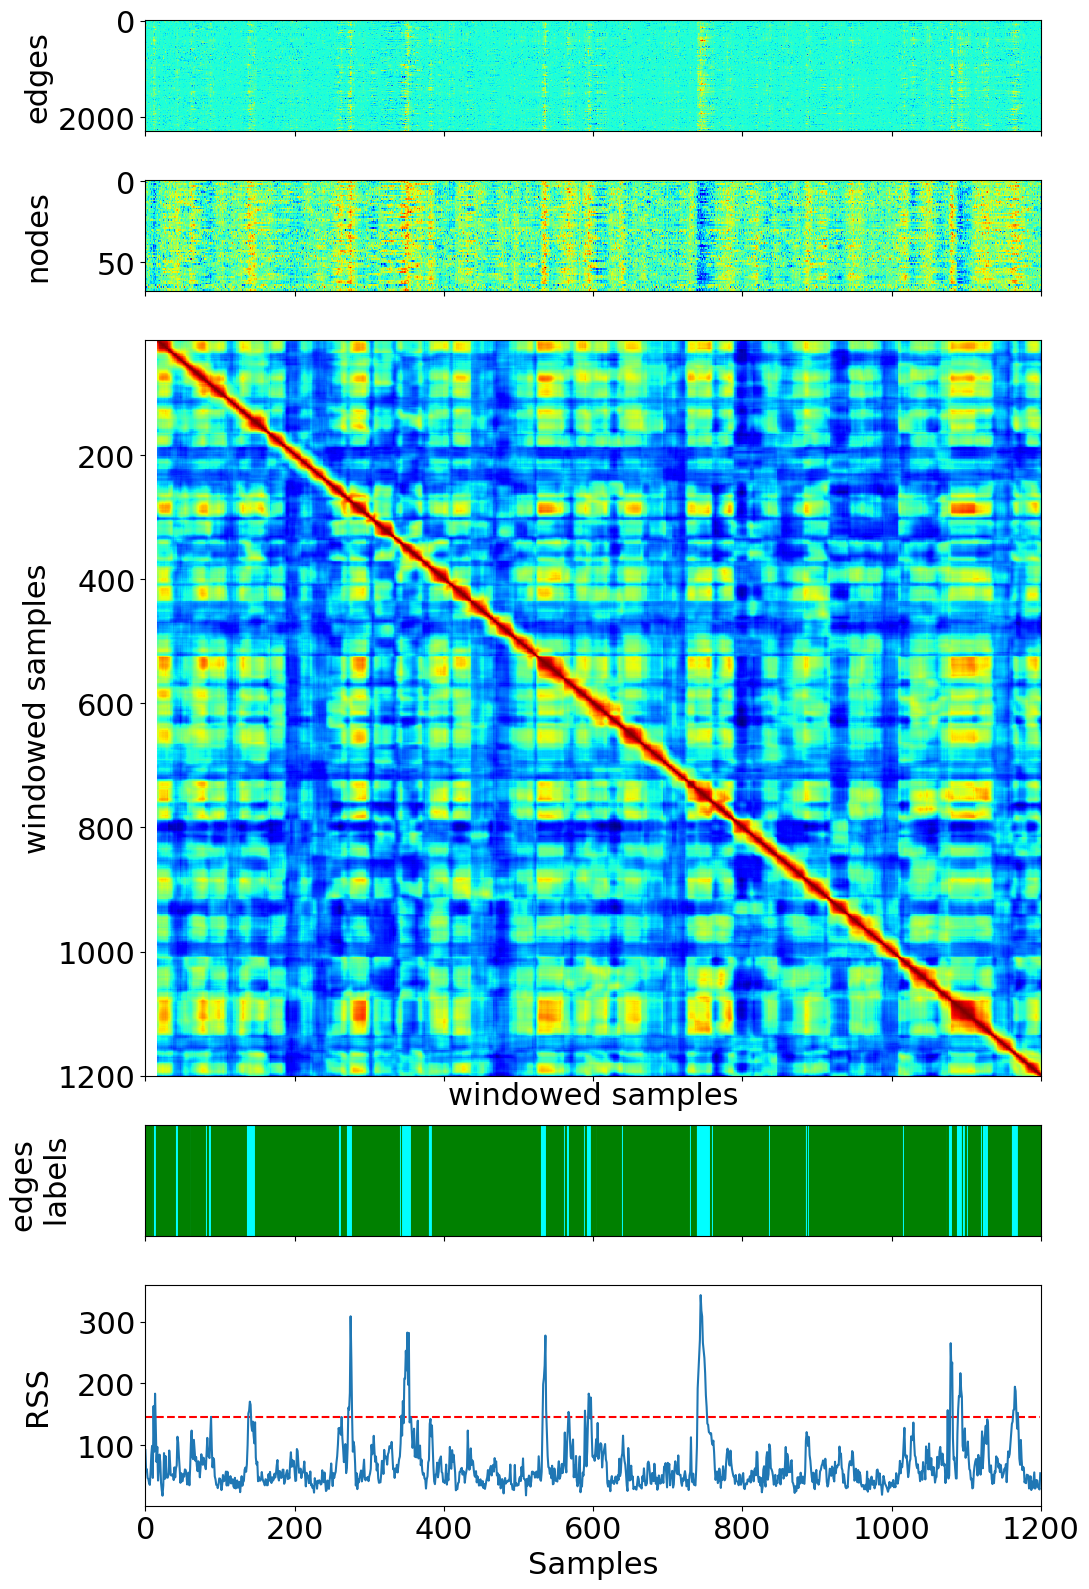

In [21]:
fig, axes = plt.subplots(5, 1, sharex=True,figsize = (11,16),
                         gridspec_kw={'height_ratios': [1.5, 1.5, 10, 1.5, 3]})
axes[0].imshow(Enm_ut_list[2].T, cmap='jet', aspect='auto', interpolation='none')
axes[0].set_ylabel('edges')

axes[1].imshow(data_list[2].T, cmap='jet', aspect='auto', interpolation='none')
axes[1].set_ylabel('nodes')#, fontsize=11)

axes[2].imshow(FCDs_list[2], cmap='jet', aspect='auto', interpolation='none', 
              extent = [windowed_time[0], windowed_time[-1], windowed_time[-1], windowed_time[0]])
axes[2].set_ylabel('windowed samples')#, fontsize=11)
axes[2].set_xlabel('windowed samples')#, fontsize=11)

for i, k in enumerate(km_Enm_labels_list[2][best_idx_Enm__list[2], :]):
    axes[3].vlines(np.arange(N_samples)[i], 0, 50, colors = km_colors[int(k)])
axes[3].set_ylim(0,50);
axes[3].set_xlim(0,1200);
axes[3].tick_params(left = False, labelleft=False)
axes[3].set_ylabel('edges \n labels \n \n')

axes[4].hlines(RSS_95th_percentile_list[2], np.arange(N_samples)[0], np.arange(N_samples)[-1], linestyles='--', color = 'red')
axes[4].plot(np.arange(N_samples), RSS_list[2])
axes[4].set_ylabel('RSS')
axes[4].set_xlabel('Samples')

fig.align_ylabels([axes[0],axes[1],axes[2],axes[-1]])
plt.tight_layout()
plt.show()

#### PCA on BOLD data

In [22]:
var_expl, PCs, PCA_data = [], [],[]
for i in range(len(data_list)):
    PCA_results = PCA_sklearn(data_list[i], N_regions)
    var_expl.append(PCA_results[0])
    PCs.append(PCA_results[1]) 
    PCA_data.append(PCA_results[2])

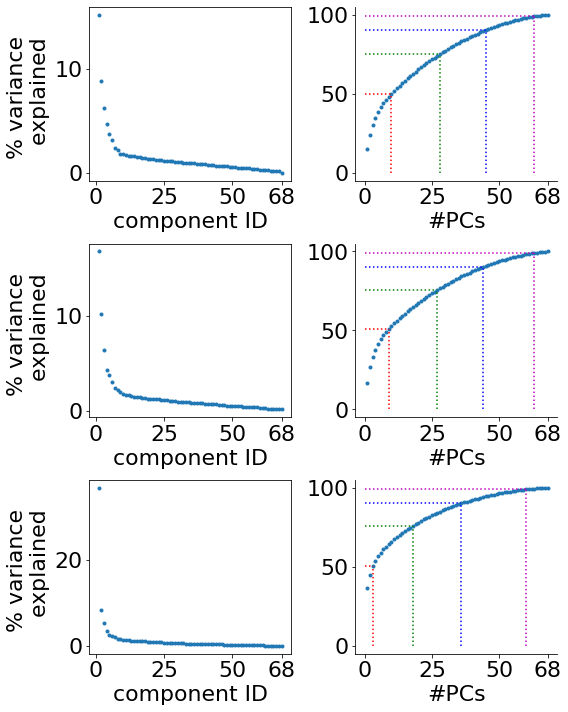

In [23]:
%matplotlib inline

fig, ax = plt.subplots(len(data_list), 2, figsize = (8,10))
#                          gridspec_kw={'height_ratios': [3, 0.75, 0.75]})
for i in range(len(data_list)):
    cvar = np.zeros(var_expl[i].shape[0])
    for n in range(var_expl[i].shape[0]):
        if n == 0:
            cvar[n] = var_expl[i][n]
        else:
            cvar[n] = var_expl[i][n] + cvar[n-1]
    n_PCs = np.arange(var_expl[i].shape[0])+1
#     plt.figure(figsize=(14,7))
#     plt.subplot(121)
#     print(n_PCs, var_expl_sklearn[i]*100)
    ax[i,0].plot(n_PCs, var_expl[i]*100, ".")
    ax[i,0].set_xlabel('component ID')
    ax[i,0].set_ylabel('% variance \n explained')
#     ax[i,0].xscale("log")

    def cum_plot(cvar, selective_v):
        a = ((np.array(np.where(cvar > selective_v))).T)+1
        return a[0]

    selective_v = [0.50, 0.75, 0.90, 0.99]
    colors = ['r', 'g', 'b', 'm']

#     plt.subplot(122)
    ax[i,1].plot(n_PCs, cvar*100, ".")
    for n in range(len(selective_v)):
        ax[i,1].vlines(cum_plot(cvar, selective_v[n]),0,cvar[(cum_plot(cvar, selective_v[n]))-1]*100, linestyle="dotted", color = colors[n],
                       label = str(int(cum_plot(cvar, selective_v[n])))+' Pcs for >'+str(int(selective_v[n]*100))+' %')
        ax[i,1].hlines(cvar[(cum_plot(cvar, selective_v[n]))-1]*100,0,cum_plot(cvar, selective_v[n]), linestyle='dotted', color = colors[n])
    sns.despine(right=True, ax=ax[i,1])
    ax[i,1].set_xticks([0,25,50,N_regions])
    ax[i,0].set_xticks([0,25,50,N_regions])
    ax[i,1].set_xlabel('#PCs')
    # ax[i,1].set_ylabel('% total \n variance \n explained')
plt.tight_layout()
plt.show()

In [24]:
# check if the PCA data == projection of data to the PCs eigenspace
# for i in range(3):
#     print(PCA_data[0][:,i] == PCs[0][:,i][:,None].T @ data_list[0].T)

##### find PC loadings

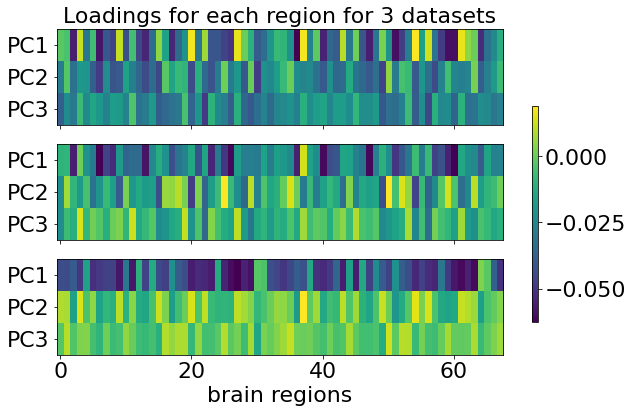

In [25]:
# loadings plot 
fig, ax = plt.subplots(3, 1, figsize = (8,6), sharex = True)
for i in range(len(data_list)):
    im_i = ax[i].imshow(np.multiply(PCs[i][:,:3],var_expl[i][:3]).T, aspect = 'auto') 
    ax[i].set_yticks(ticks = [0,1,2], labels = ["PC1","PC2","PC3"])
ax[0].set_title('Loadings for each region for {} datasets'.format(len(data_list)));
ax[2].set_xlabel('brain regions')
cbar_ax = fig.add_axes([0.95, 0.2, 0.01, 0.5])
plt.colorbar(im_i, cbar_ax)
plt.show()

In [26]:
# for orig dataset
PCs_loadings2 = np.multiply(PCs[2][:,:3],var_expl[2][:3]).T

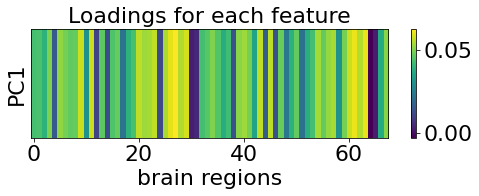

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize = (8,2), sharex = True)

im_PC1 = ax1.imshow(-PCs_loadings2[0,:][None,:], aspect = 'auto') 
ax1.tick_params(left = False, labelleft=False)
ax1.set_title('Loadings for each feature');
ax1.set_xlabel('brain regions')
ax1.set_ylabel('PC1')

plt.colorbar(im_PC1, ax = ax1)
plt.show()

##### Combine loadings and weights for a 2D **Brain Plot**

In [28]:
colours_loadings_PC1 = im_PC1.cmap(im_PC1.norm(-PCs_loadings2[0,:][None,:]))

In [29]:
centersDK = pd.read_csv('centresDK.csv')
centersDK = centersDK.T

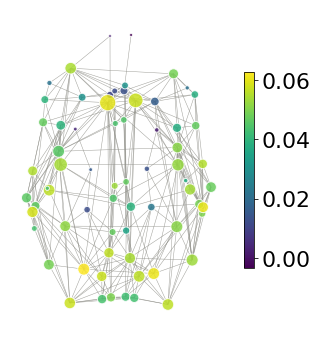

In [30]:
# weights determine the size, loadings determine the color
create_2D_brain_plot(weights, centersDK.values, threshold=100,
                    color_nodes=colours_loadings_PC1.squeeze(), mappable=im_PC1,
                    size_nodes=weights.sum(axis = 0)/100,
                   alpha_node=0.85)

##### PCA results combined with classes on edge series and coactivation events

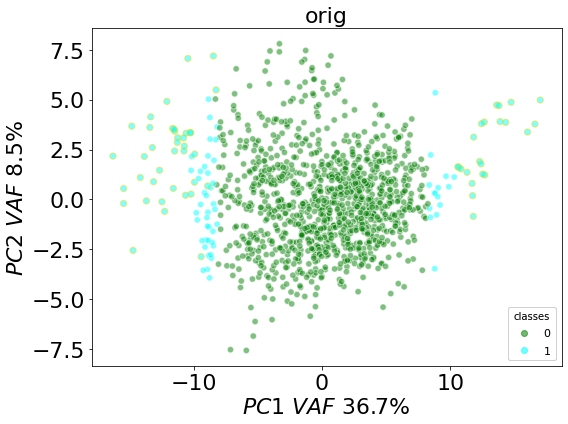

In [135]:
%matplotlib inline

fig, ax = plt.subplots(1,1, sharex='col',figsize = (8,6))

i = 2 #2nd dataset
j=0   #1st kmeans clustering
data2_PCA = ax.scatter(PCA_data[i][:,0],
                              PCA_data[i][:,1],
                              c=km_Enm_labels_list[i][j], edgecolors = RSS_colors_strings[i], s=40,
                              cmap = ListedColormap(['green', 'cyan']), 
                              alpha = 0.5)
if j == 0:

    ax.set_title(preprocessings[i])
    ax.set_ylabel(r'$PC2 \ VAF \ {}\%$'.format((100*var_expl[2][1]).round(1)))
if i == len(data_list)-1:
    ax.set_xlabel(r'$PC1 \ VAF \ {}\%$'.format((100*var_expl[2][0]).round(1)))

# produce a legend with the unique colors from the scatter
if i == len(data_list)-1:
    legend1 = ax.legend(*data2_PCA.legend_elements(),
                            loc="lower right", title="classes", prop={'size': 11})
    ax.add_artist(legend1)

plt.tight_layout()
plt.show()

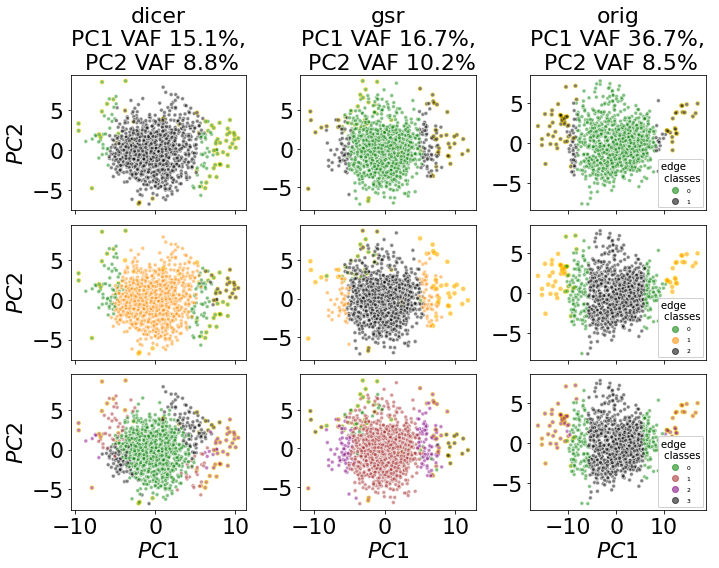

In [136]:
%matplotlib inline

fig, ax = plt.subplots(3,3, sharex='col',figsize = (10,8))

for i in range(len(data_list)):
    for j in range(len(n_Enm_clusters)):
        data_PCA = ax[j,i].scatter(PCA_data[i][:,0],
                                      PCA_data[i][:,1],
                                      c=km_Enm_labels_list[i][j], edgecolors = RSS_colors_strings[i], s=15,
                                      cmap = ListedColormap(km_colors), 
                                      alpha = 0.5)
        if j == 0:
    
            ax[j,i].set_title(preprocessings[i] + '\n PC1 VAF {}%, \n PC2 VAF {}%'.format((100*var_expl[i][0]).round(1), (100*var_expl[i][1]).round(1)))
            ax[i,j].set_ylabel(r'$PC2$')
        if i == len(data_list)-1:
            ax[i,j].set_xlabel(r'$PC1$')
            
# produce a legend with the unique colors from the scatter
        if i == len(data_list)-1:
            legend1 = ax[j,i].legend(*data_PCA.legend_elements(),
                                    loc="lower right", title="edge \n classes", prop={'size': 6})
            ax[j,i].add_artist(legend1)

plt.tight_layout()
plt.show()

#### Find FCD states

In [33]:
n_FCD_clusters = [3, 4, 5, 6]
km_FCsut_labels_list, silh_FCsut_avg_list, best_idx_FCsut_list = run_KMeans(FCs_ut_list, n_FCD_clusters)

100%|█████████████████████████████████████████████| 3/3 [00:31<00:00, 10.59s/it]


In [34]:
km_df_list, km_windowed_time_df_list, grouped_km_df_list = \
calc_FCD_states(data_list, windowed_time, 10,
                km_FCsut_labels_list, best_idx_FCsut_list, km_colors)

 33%|███████████████                              | 1/3 [00:00<00:00,  6.34it/s]

check: 23 >= 23
check: 22 >= 22


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.80it/s]

check: 20 >= 19


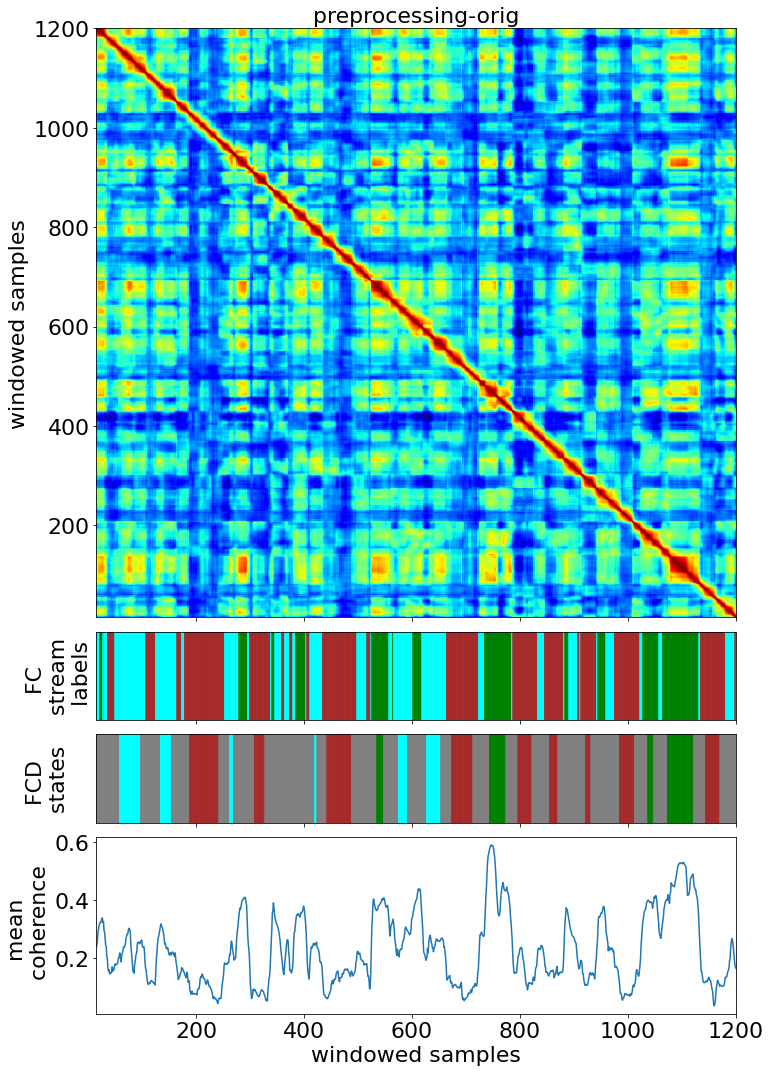

In [35]:
%matplotlib inline

fig, ax = plt.subplots(4, 1, sharex=True,figsize = (11,15),
                      gridspec_kw={'height_ratios': [10, 1.5, 1.5, 3]})#, 0.75, 0.75]})
use_time = False
if use_time == True:
    xlabel = r'$time \ [sec]$'
else:
    xlabel = 'samples'

# FCD plot
imFCD = ax[0].imshow(FCDs_list[2], cmap='jet', aspect='auto', interpolation='none',
                    extent = [windowed_time[0], windowed_time[-1],windowed_time[0], windowed_time[-1]])
ax[0].set_title('preprocessing-'+preprocessings[2])
ax[0].set_ylabel(r'windowed '+xlabel)#, fontsize=11)

# k-means clustering plot
# for j in range(len(subject_data)):
for i, k in enumerate(km_FCsut_labels_list[2][best_idx_FCsut_list[2], :]):
    ax[1].vlines(windowed_time[i], 0, 50, colors = km_colors[int(k)])
ax[1].set_ylim(0,50);
ax[1].tick_params(left = False, labelleft=False)
ax[1].set_ylabel('FC \n stream \n labels')

for i, k in enumerate(km_windowed_time_df_list[2]["kmeans colors"]):
    ax[2].vlines(windowed_time[i], 0, 50, colors = k)
# ax[1].set_xlim(0,N_FCD_upper)
ax[2].set_ylim(0,50);
ax[2].tick_params(left = False, labelleft=False)
ax[2].set_ylabel('FCD \n states \n')
# ax[2].set_title('k_means {}-'.format(element_of_n_clusters + n_FCstream_clusters[0]) + preprocessings[2])

# fc-stream plot
ax[3].plot(windowed_time, FC_stream[2])
ax[3].set_ylabel('mean \n coherence')
# ax[2].set_title('FC stream-'+preprocessings[2])
ax[3].set_xlabel('windowed ' + xlabel)#, fontsize=15)

fig.align_ylabels([ax[1], ax[2]])
plt.tight_layout()
plt.show()

##### FCD states on PCA results

In [36]:
grouped_km_df_list[2].index

MultiIndex([(-1,  'grey'),
            ( 0, 'green'),
            ( 1,  'cyan'),
            ( 2, 'brown')],
           names=['kmeans labels', 'kmeans colors'])

In [37]:
grouped_km_df_list[2].index.shape[0]

4

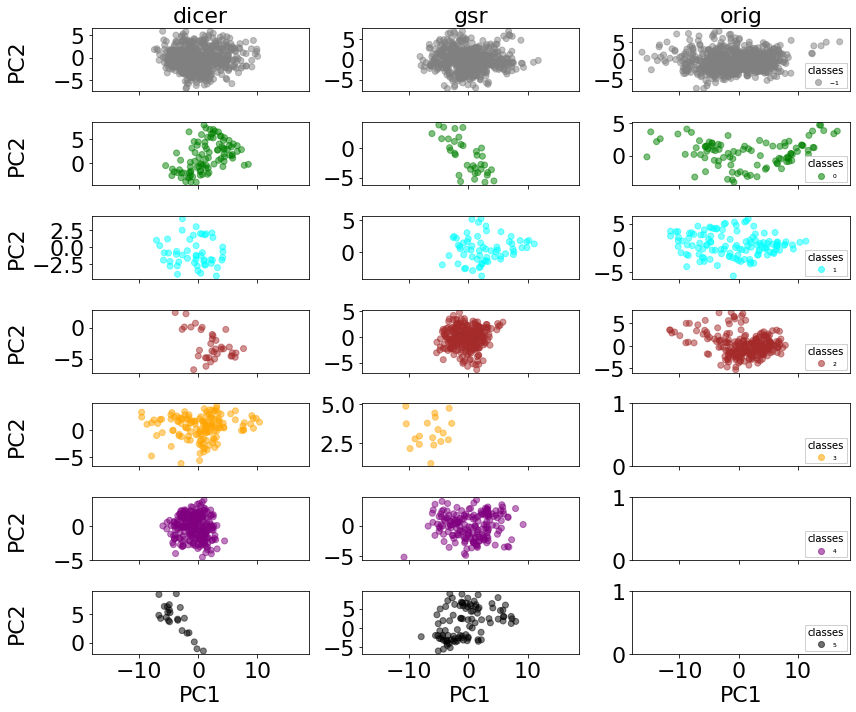

In [38]:
%matplotlib inline
t = np.arange(N_samples)
up_to_sample = t.shape[0]# - 1000 # change the size of data under inspection
fig, axes = plt.subplots(7,#grouped_km_df_list[2].index.shape[0],
                         len(data_list), sharex=True, figsize = (12,10))
colors_classes_all = [[] for _ in range(len(data_list))]
for k in range(len(data_list)):
    for i,j in zip(grouped_km_df_list[k].index, 
                   range(grouped_km_df_list[k].index.shape[0])):
        # print(j)
        colors_classes_all[k].append(grouped_km_df_list[k][i[0]].index[0])
        all_PCA = axes[j,k].scatter(PCA_data[k][:,0][grouped_km_df_list[k][i[0]].values[0]],
                          PCA_data[k][:,1][grouped_km_df_list[k][i[0]].values[0]],
                          c = km_df_list[k]['kmeans labels'].values.squeeze()[grouped_km_df_list[k][i[0]].values[0]],# edgecolors = RSS_colors_strings[:up_to_sample],
                          alpha = 0.5, cmap = ListedColormap(grouped_km_df_list[k][i[0]].index[0]))# c=km_labels[2][0], s=15, 
        legend1 = axes[j,len(data_list)-1].legend(*all_PCA.legend_elements(),
                   loc="lower right", title="classes", prop={'size': 6})
        axes[j,len(data_list)-1].add_artist(legend1)
        axes[j,0].set_ylabel('PC2')
    axes[0, k].set_title('{}'.format(preprocessings[k]))
    axes[-1, k].set_xlabel('PC1')


fig.align_ylabels(axes)
plt.tight_layout()
plt.show()

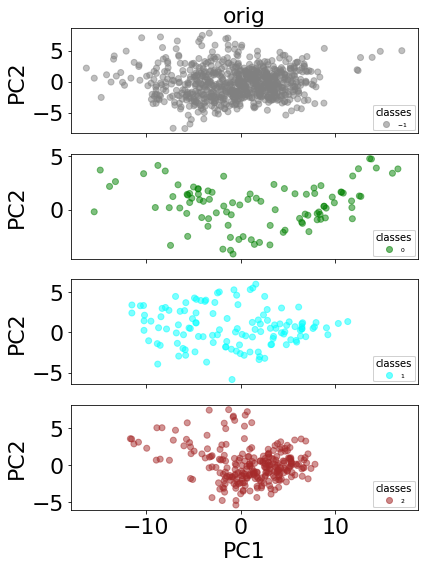

In [39]:
%matplotlib inline
t = np.arange(N_samples)
up_to_sample = t.shape[0]# - 1000 # change the size of data under inspection
fig, axes = plt.subplots(grouped_km_df_list[2].index.shape[0], 1, sharex=True, figsize = (6,8))
colors_classes = []
for i,j in zip(grouped_km_df_list[2].index, 
               range(grouped_km_df_list[2].index.shape[0])):
    colors_classes.append(grouped_km_df_list[2][i[0]].index[0])
    orig_PCA = axes[j].scatter(PCA_data[2][:,0][grouped_km_df_list[2][i[0]].values[0]],
                      PCA_data[2][:,1][grouped_km_df_list[2][i[0]].values[0]],
                      c = km_df_list[2]['kmeans labels'].values.squeeze()[grouped_km_df_list[2][i[0]].values[0]],# edgecolors = RSS_colors_strings[:up_to_sample],
                      alpha = 0.5, cmap = ListedColormap(grouped_km_df_list[2][i[0]].index[0]))# c=km_labels[2][0], s=15, 
    legend1 = axes[j].legend(*orig_PCA.legend_elements(),
               loc="lower right", title="classes", prop={'size': 6})
    axes[j].add_artist(legend1)
    axes[j].set_ylabel('PC2')
axes[0].set_title('orig')
axes[-1].set_xlabel('PC1')


fig.align_ylabels(axes)
plt.tight_layout()
plt.show()

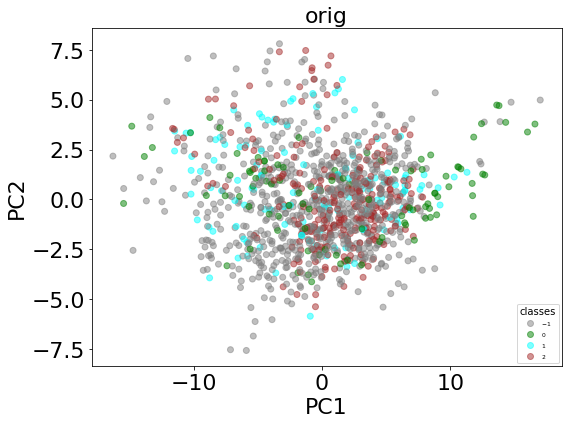

In [40]:
%matplotlib inline

up_to_sample = t.shape[0]# - 1000 # change the size of data under inspection
plt.figure(figsize = (8,6))

orig_PCA_FCD = plt.scatter(PCA_data[2][:,0][:up_to_sample],
                      PCA_data[2][:,1][:up_to_sample],
                      c = km_df_list[2]['kmeans labels'].values.squeeze()[:up_to_sample],# edgecolors = RSS_colors_strings[:up_to_sample],
                      cmap = ListedColormap(colors_classes),
                      alpha = 0.5)
plt.legend(*orig_PCA_FCD.legend_elements(),
           loc="lower right", title="classes", prop={'size': 6})
plt.title('orig')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

#### PHATE

In [41]:
# fitting
phate_operator2d_eucl = phate.PHATE(n_components=2 ,knn_dist='euclidean', mds_dist='euclidean', n_jobs=-1)
data_2Dphate_eucl = []
phate_fit2d_eucl = []
for i in range(len(data_list)):
    print(i+1,' iteration'.format(i+1))
    phate_fit2d_eucl.append(phate_operator2d_eucl.fit(data_list[i]))
    print('\n Transformation now starts \n')
    data_2Dphate_eucl.append(phate_fit2d_eucl[i].transform(data_list[i]))

1  iteration
Running PHATE on 1200 observations and 68 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.17 seconds.
  Calculating affinities...
  Calculated affinities in 0.05 seconds.
Calculated graph and diffusion operator in 0.24 seconds.

 Transformation now starts 

Calculating optimal t...
  Automatically selected t = 21
Calculated optimal t in 1.77 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.93 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.92 seconds.
2  iteration
Running PHATE on 1200 observations and 68 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.15 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.21 seconds.

 Transformation now starts 

Calculating optimal t...
  Automatically selected t = 24
Calculated optimal t in 2.41 s

In [173]:
FC_list[0].shape

(68, 68)

In [174]:
# normalized kernel matrix
phate_fit2d_eucl[2].diff_op.shape

(1200, 1200)

In [43]:
# potential distance matrix
phate_fit2d_eucl[2].diff_potential.shape

(1200, 1200)

In [44]:
# phate loadings for orig dataset
# NOT RIGOROUS!, but checks correspondence with PCA loadings
phate_loadings_orig = data_2Dphate_eucl[2].T @ data_list[2]

In [45]:
PCs_loadings2.shape

(3, 68)

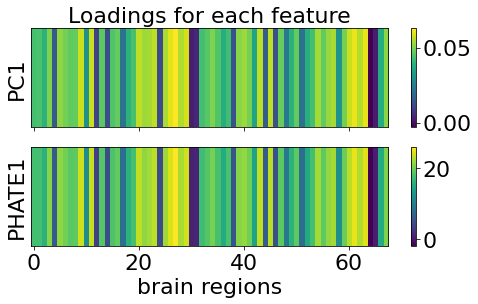

In [177]:
fig, ax = plt.subplots(2, 1, figsize = (8,4), sharex = True)
ax1 , ax2 = ax.ravel()

im_PC1 = ax1.imshow(-PCs_loadings2[0,:][None,:], aspect = 'auto') 
im_phate = ax2.imshow(phate_loadings_orig.values[0,:][None,:], aspect = 'auto')
ax1.tick_params(left = False, labelleft=False)
ax2.tick_params(left = False, labelleft=False)
ax1.set_title('Loadings for each feature');
ax2.set_xlabel('brain regions')

ax1.set_ylabel('PC1')
ax2.set_ylabel('PHATE1')
plt.colorbar(im_PC1, ax = ax1)
plt.colorbar(im_phate, ax = ax2)
plt.show()

##### **PHATE with edge classes**

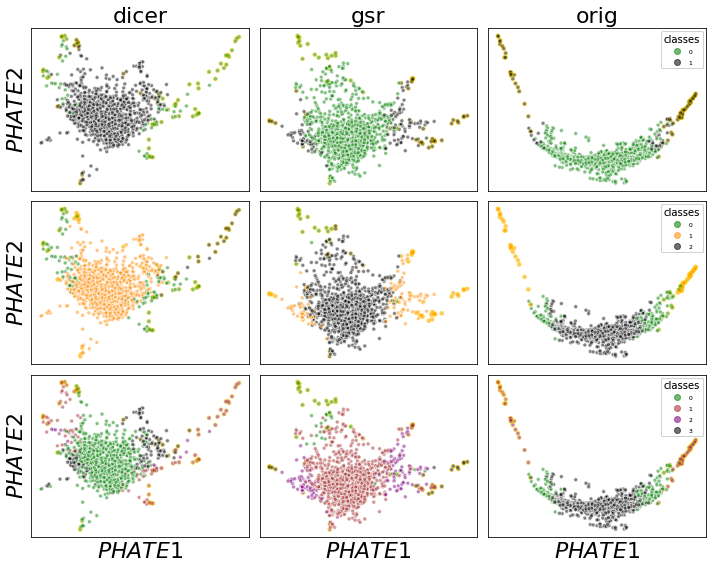

In [137]:
%matplotlib inline

fig, ax = plt.subplots(3,3, sharex='col',figsize = (10,8))

for i in range(len(data_list)):
    for j in range(len(n_Enm_clusters)):
        data_PHATE = ax[j,i].scatter(data_2Dphate_eucl[i][:,0],
                                      data_2Dphate_eucl[i][:,1],
                                      c=km_Enm_labels_list[i][j], edgecolors = RSS_colors_strings[i], s=15, 
                                      cmap=ListedColormap(km_colors),alpha = 0.5)
        ax[j,i].tick_params(labelleft=False, left = False, labelbottom=False, bottom=False)
        if j == 0:
    
            ax[j,i].set_title(preprocessings[i])
            ax[i,j].set_ylabel(r'$PHATE2$')
        if i == len(data_list)-1:
            ax[i,j].set_xlabel(r'$PHATE1$')
            
# produce a legend with the unique colors from the scatter
        if i == len(data_list)-1:
            legend1 = ax[j,i].legend(*data_PHATE.legend_elements(),
                                    loc="upper right", title="classes", prop={'size': 6})
            ax[j,i].add_artist(legend1)

plt.tight_layout()
plt.show()

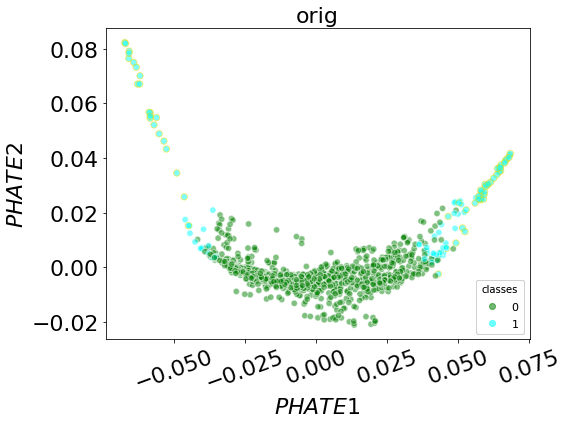

In [138]:
%matplotlib inline

fig, ax = plt.subplots(1,1, sharex='col',figsize = (8,6))

i = 2 # orig dataset
j=0 # 1st kmeans cluster
orig_PHATE = ax.scatter(data_2Dphate_eucl[i][:,0],
                          data_2Dphate_eucl[i][:,1],
                          c=km_Enm_labels_list[i][j], edgecolors = RSS_colors_strings[i], s=40,
                          cmap = ListedColormap(['green', 'cyan']), 
                          alpha = 0.5)
if j == 0:

    ax.set_title(preprocessings[i])
    ax.set_ylabel(r'$PHATE2$')
if i == len(data_list)-1:
    ax.set_xlabel(r'$PHATE1$')

# produce a legend with the unique colors from the scatter
if i == len(data_list)-1:
    legend1 = ax.legend(*orig_PHATE.legend_elements(),
                            loc="lower right", title="classes", prop={'size': 11})
    ax.add_artist(legend1)
ax.tick_params(axis='x', labelrotation= 20)
plt.tight_layout()
plt.show()

##### **PHATE with FCD classes**

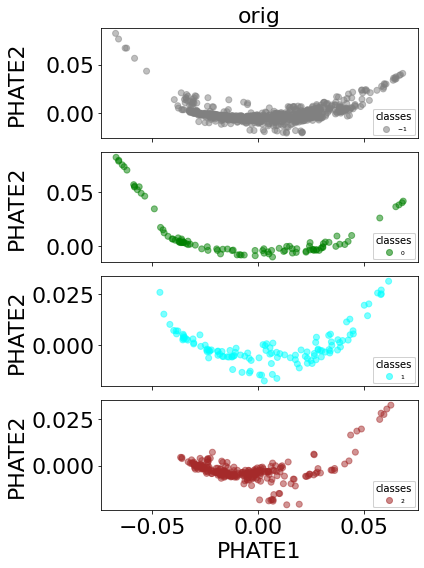

In [49]:
%matplotlib inline

up_to_sample = t.shape[0]# - 1000 # change the size of data under inspection
fig, axes = plt.subplots(grouped_km_df_list[2].index.shape[0], 1, sharex=True, figsize = (6,8))
for i,j in zip(grouped_km_df_list[2].index, 
               range(grouped_km_df_list[2].index.shape[0])):
    orig_PHATE_FCD_sep = axes[j].scatter(data_2Dphate_eucl[2][:,0][grouped_km_df_list[2][i[0]].values[0]],
                      data_2Dphate_eucl[2][:,1][grouped_km_df_list[2][i[0]].values[0]],
                      c = km_df_list[2]['kmeans labels'].values.squeeze()[grouped_km_df_list[2][i[0]].values[0]],
                      alpha = 0.5, cmap = ListedColormap(grouped_km_df_list[2][i[0]].index[0]))
    legend1 = axes[j].legend(*orig_PHATE_FCD_sep.legend_elements(),
                            loc="lower right", title="classes", prop={'size': 6})
    axes[j].add_artist(legend1)
    axes[j].set_ylabel('PHATE2')
axes[0].set_title('orig')
axes[-1].set_xlabel('PHATE1')
fig.align_ylabels(axes)


plt.tight_layout()
plt.show()

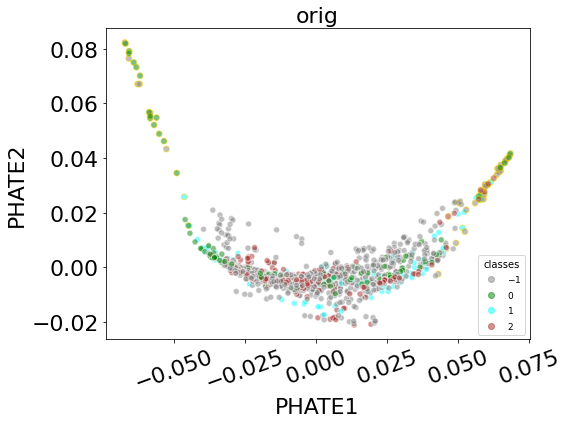

In [140]:
%matplotlib inline

up_to_sample = t.shape[0]# - 1000 # change the size of data under inspection
plt.figure(figsize = (8,6))
orig_PHATE_FCD_all = plt.scatter(data_2Dphate_eucl[2][:,0][:up_to_sample],
                      data_2Dphate_eucl[2][:,1][:up_to_sample],
                      c = km_df_list[2]['kmeans labels'].values.squeeze()[:up_to_sample], edgecolors = RSS_colors_strings[2],
                      cmap = ListedColormap(colors_classes),
                      alpha = 0.5)
plt.legend(*orig_PHATE_FCD_all.legend_elements(),
           loc="lower right", title="classes", prop={'size': 9})
plt.title('orig')
plt.xlabel('PHATE1')
plt.ylabel('PHATE2')

plt.tick_params(axis='x', labelrotation= 20)
plt.tight_layout()
plt.show()

### Employing knowledge from T-PHATE paper

#### T-PHATE

#### incorporate TR vector as a feature in the dataset -> dataset+time

In [51]:
data_time_list = data_list
for i in range(len(data_time_list)):
    data_time_list[i]["TR"] = np.arange(N_samples)*TR

In [52]:
data_time_list[0]

lh-bankssts  lh-caudalanteriorcingulate  lh-caudalmiddlefrontal  \
0        0.206443                   -1.465367                4.084419   
1        0.116886                   -2.333723                2.238088   
2        1.232589                   -2.040010                0.974644   
3        1.118970                   -1.296917                0.958040   
4        0.100683                    0.386902                1.402241   
...           ...                         ...                     ...   
1195    -1.357144                    0.933375                0.924940   
1196    -0.772329                   -0.270763                0.996177   
1197    -1.355101                    0.224017                1.130780   
1198    -0.184000                   -0.407348                0.853263   
1199    -0.145714                   -1.146469                2.173433   

      lh-cuneus  lh-entorhinal  lh-fusiform  lh-inferiorparietal  \
0     -1.733060      -0.737857     0.350472             2.758422   
1     -0.830037      -0.241132    -0.039171             1.442471   
2      0.341626       0.582959     0.446755             1.554931   
3      0.382648       1.022257    -0.429716             0.015399   
4     -1.766151       1.843217    -0.486256             0.851043   
...         ...            ...          ...                  ...   
1195   0.837703       0.620696    -0.176992             0.038616   
1196  -0.373253      -1.588576    -0.947083             1.286283   
1197  -0.732333      -0.654852    -0.155605            -0.328576   
1198  -0.341117      -0.365738     1.071174             0.701715   
1199  -0.027424       0.293305    -0.071266             1.497809   

      lh-inferiortemporal  lh-isthmuscingulate  lh-lateraloccipital  ...  \
0                1.105744             0.968617            -0.967686  ...   
1                0.273978             1.257183            -0.147457  ...   
2                1.961802             0.542017             0.720770  ...   
3                1.547000             0.985746            -0.181659  ...   
4               -0.085654            -0.345863            -0.711487  ...   
...                   ...                  ...                  ...  ...   
1195            -1.046475            -1.485113             1.727276  ...   
1196            -0.554532             1.014981             1.402737  ...   
1197            -0.640137            -0.463351             1.211225  ...   
1198            -0.963126             0.091685             1.207475  ...   
1199            -0.008160             0.810236             1.030156  ...   

      rh-rostralmiddlefrontal  rh-superiorfrontal  rh-superiorparietal  \
0                    1.799663            0.402852            -1.528283   
1                    0.690275            0.223750            -1.817279   
2                   -0.180876           -1.323536            -0.216455   
3                    0.656966           -0.816422            -0.863573   
4                    0.959669            1.039893            -1.335034   
...                       ...                 ...                  ...   
1195                 0.494767            0.424173             1.130437   
1196                 0.082183            0.171002             0.823793   
1197                 1.066290           -0.400177            -0.157994   
1198                 0.691439            0.216600             0.048257   
1199                 1.338148            0.475010             0.609030   

      rh-superiortemporal  rh-supramarginal  rh-frontalpole  rh-temporalpole  \
0               -0.134759         -2.225805        1.271628        -0.759128   
1               -1.221777         -2.001819        1.233562         1.078272   
2                0.122552         -0.985892       -0.066353        -2.953182   
3                0.036440         -0.556478        1.064780        -0.843362   
4                0.588998         -1.025476        1.015192         0.839830   
...                   ...     

#### PHATE+Time

In [53]:
phate_time_operator2d_eucl = phate.PHATE(n_components=2 ,knn_dist='euclidean', mds_dist='euclidean', n_jobs=-1)
data_time_2Dphate_eucl = []
phate_time_fit2d_eucl = []
for i in range(len(data_list)):
    print('\n',i+1,' iteration'.format(i+1))
    phate_time_fit2d_eucl.append(phate_time_operator2d_eucl.fit(data_time_list[i]))
    print('\n Transformation now starts')
    data_time_2Dphate_eucl.append(phate_time_fit2d_eucl[i].transform(data_time_list[i]))


 1  iteration
Running PHATE on 1200 observations and 69 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.03 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.07 seconds.

 Transformation now starts
Calculating optimal t...
  Automatically selected t = 19
Calculated optimal t in 1.87 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.01 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.68 seconds.

 2  iteration
Running PHATE on 1200 observations and 69 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.07 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.12 seconds.

 Transformation now starts
Calculating optimal t...
  Automatically selected t = 20
Calculated optimal t in 2.40 s

##### PHATE loadings

In [74]:
# phate loadings for orig dataset
# NOT RIGOROUS!, but checks correspondence with PCA loadings
phate_time_loadings_orig = data_time_2Dphate_eucl[2].T @ data_list[2]

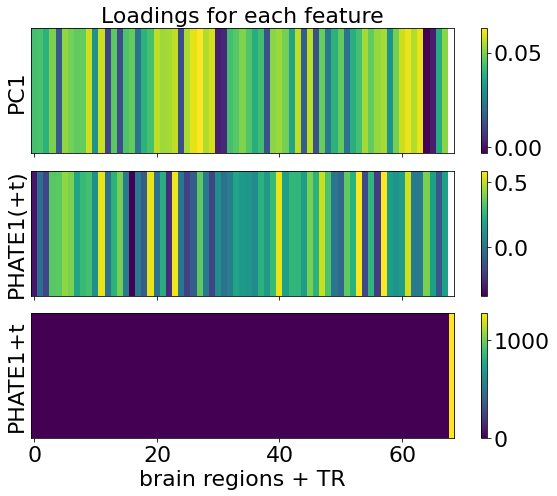

In [165]:
fig, ax = plt.subplots(3, 1, figsize = (8,7), sharex = True)
ax1 , ax2, ax3 = ax.ravel()

im_PC1 = ax1.imshow(-PCs_loadings2[0,:][None,:], aspect = 'auto') 
im_phate_notime = ax2.imshow(-phate_time_loadings_orig.values[0,:-1][None,:], aspect = 'auto')
im_phate_time = ax3.imshow(phate_time_loadings_orig.values[0,:][None,:], aspect = 'auto')
ax1.tick_params(left = False, labelleft=False)
ax2.tick_params(left = False, labelleft=False)
ax3.tick_params(left = False, labelleft=False)
ax1.set_title('Loadings for each feature');
ax3.set_xlabel('brain regions + TR')

ax1.set_ylabel('PC1')
ax2.set_ylabel('PHATE1(+t)')
ax3.set_ylabel('PHATE1+t')
plt.colorbar(im_PC1, ax = ax1)
plt.colorbar(im_phate_notime, ax = ax2)
plt.colorbar(im_phate_time, ax = ax3)
plt.tight_layout()
plt.show()

In [166]:
colours_loadings_phate1_t = im_phate_notime.cmap(im_phate_notime.norm(-phate_time_loadings_orig.values[0,:-1][None,:]))

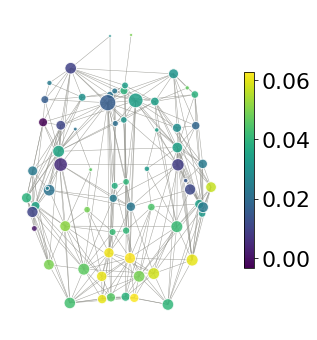

In [167]:
create_2D_brain_plot(weights, centersDK.values, threshold=100,
                    color_nodes=colours_loadings_phate1_t.squeeze(), mappable=im_PC1,
                    size_nodes=weights.sum(axis = 0)/100,
                   alpha_node=0.85)

##### PHATE+time and edge classes

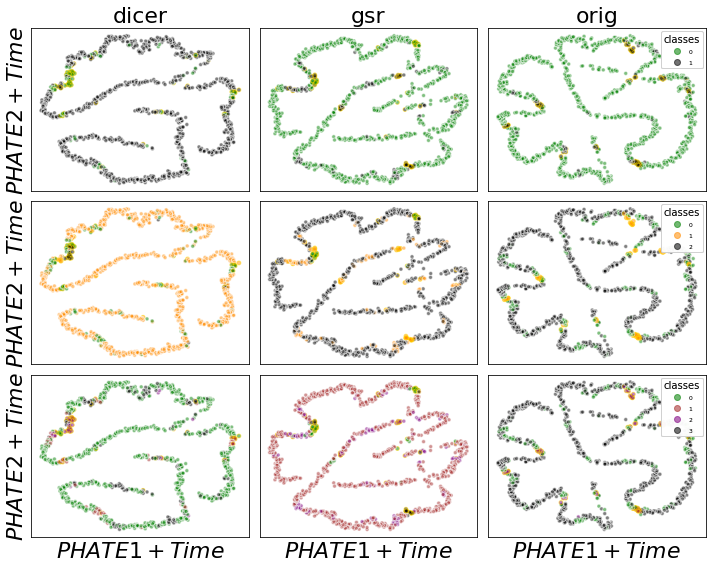

In [161]:
%matplotlib inline

fig, ax = plt.subplots(3,3, sharex='col',figsize = (10,8))

for i in range(len(data_time_list)):
    for j in range(len(n_Enm_clusters)):
        data_time_PHATE = ax[j,i].scatter(data_time_2Dphate_eucl[i][:,0],
                                      data_time_2Dphate_eucl[i][:,1],
                                      c=km_Enm_labels_list[i][j], edgecolors = RSS_colors_strings[i], s=15, 
                                      cmap=ListedColormap(km_colors),alpha = 0.5)
        ax[j,i].tick_params(labelleft=False, left = False, labelbottom=False, bottom=False)
        if j == 0:
    
            ax[j,i].set_title(preprocessings[i])
            ax[i,j].set_ylabel(r'$PHATE2+Time$')
        if i == len(data_time_list)-1:
            ax[i,j].set_xlabel(r'$PHATE1+Time$')
            
# produce a legend with the unique colors from the scatter
        if i == len(data_time_list)-1:
            legend1 = ax[j,i].legend(*data_time_PHATE.legend_elements(),
                                    loc="upper right", title="classes", prop={'size': 6})
            ax[j,i].add_artist(legend1)

plt.tight_layout()
plt.show()

##### PHATE+time and FCD states

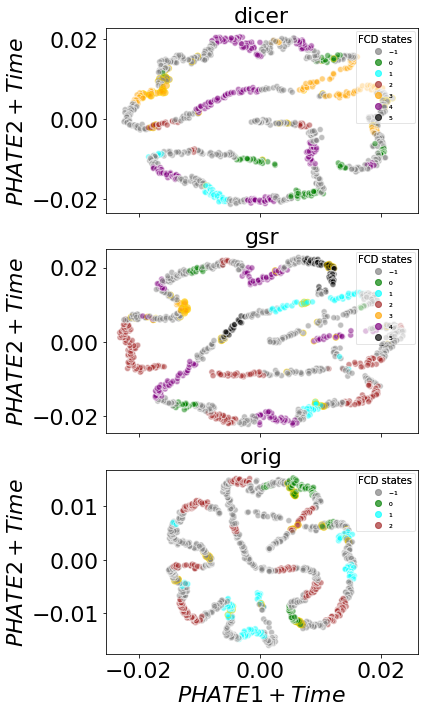

In [162]:
%matplotlib inline

fig, ax = plt.subplots(3,1, sharex='col',figsize = (6,10))

for i in range(len(data_time_list)):
    data_time_PHATE_FCD = ax[i].scatter(data_time_2Dphate_eucl[i][:,0],
                                  data_time_2Dphate_eucl[i][:,1],
                                  c=km_df_list[i]['kmeans labels'].values.squeeze(), edgecolors = RSS_colors_strings[i],#[:up_to_sample],
                                  cmap=ListedColormap(colors_classes_all[i]),alpha = 0.5)
    
    ax[i].set_title(preprocessings[i])
    ax[i].set_ylabel(r'$PHATE2+Time$')
    if i == len(data_time_list)-1:
        ax[i].set_xlabel(r'$PHATE1+Time$')
            
# produce a legend with the unique colors from the scatter
# if i == len(data_time_list)-1:
    legend1 = ax[i].legend(*data_time_PHATE_FCD.legend_elements(),
                            loc="upper right", title="FCD states", prop={'size': 6},
                          framealpha = 0.3)
    ax[i].add_artist(legend1)
fig.align_ylabels(ax)
plt.tight_layout()
plt.show()

#### 3d PHATE+Time

In [56]:
phate_time_operator3d_eucl = phate.PHATE(n_components=3 ,knn_dist='euclidean', mds_dist='euclidean', n_jobs=-1)
data_time_3Dphate_eucl = []
phate_time_fit3d_eucl = []
for i in range(len(data_list)):
    print('\n',i+1,' iteration'.format(i+1))
    phate_time_fit3d_eucl.append(phate_time_operator3d_eucl.fit(data_time_list[i]))
    print('\n Transformation now starts')
    data_time_3Dphate_eucl.append(phate_time_fit3d_eucl[i].transform(data_time_list[i]))


 1  iteration
Running PHATE on 1200 observations and 69 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.04 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.08 seconds.

 Transformation now starts
Calculating optimal t...
  Automatically selected t = 19
Calculated optimal t in 1.55 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.74 seconds.
Calculating metric MDS...
Calculated metric MDS in 137.15 seconds.

 2  iteration
Running PHATE on 1200 observations and 69 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.06 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.11 seconds.

 Transformation now starts
Calculating optimal t...
  Automatically selected t = 20
Calculated optimal t in 1.54

##### plotly 3d

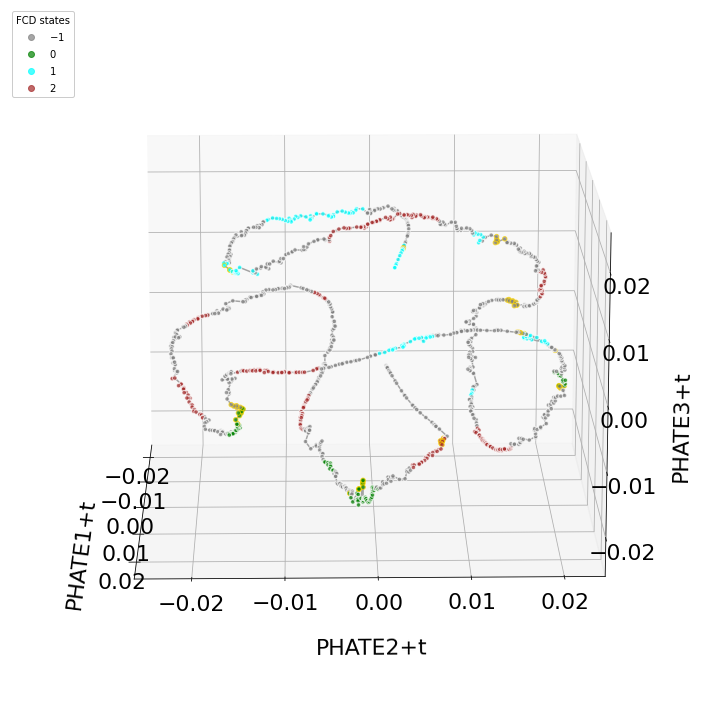

In [163]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
# for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
phate_time_3d_plot = ax.scatter3D(data_time_3Dphate_eucl[2][:,0],
                                    data_time_3Dphate_eucl[2][:,1],
                                    data_time_3Dphate_eucl[2][:,2],
                                    c=km_df_list[i]['kmeans labels'].values.squeeze(), edgecolors = RSS_colors_strings[i],
                                    cmap=ListedColormap(colors_classes_all[2]),
                                    s=20, alpha = 0.7)
ax.plot3D(data_time_3Dphate_eucl[2][:,0],
         data_time_3Dphate_eucl[2][:,1],
         data_time_3Dphate_eucl[2][:,2],
         c='grey',
         alpha = 0.7)

legend1 = ax.legend(*phate_time_3d_plot.legend_elements(),
                        loc="upper left", title="FCD states", prop={'size': 10},
                      framealpha = 1)

ax.set_xlabel('PHATE1+t', labelpad=30.5)
ax.set_ylabel('PHATE2+t', labelpad=30.5)
ax.set_zlabel('PHATE3+t', labelpad=30.5)

# ax.yaxis._axinfo['label']['space_factor'] = 50.0

plt.tight_layout()
ax.view_init(15, angle)

plt.show()

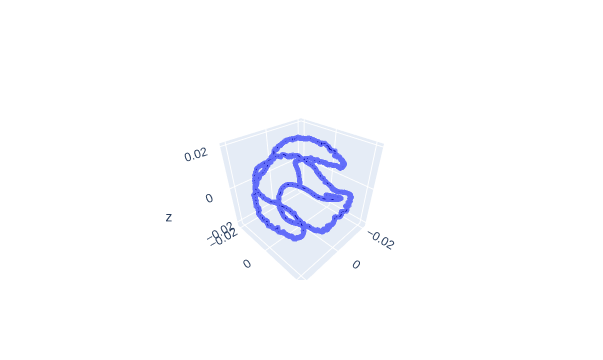

In [90]:
fig = go.Figure(data=[go.Scatter3d(x=data_time_3Dphate_eucl[0][:,0],
                                   y=data_time_3Dphate_eucl[0][:,1],
                                   z=data_time_3Dphate_eucl[0][:,2],
                                   # mode='markers',
                                   marker=dict(
                                        size=3,
                                        color=N_samples,                # set color to an array/list of desired values
                                        # colorscale='Viridis',   # choose a colorscale
                                        opacity=0.8))])
fig.show()